<a href="https://colab.research.google.com/github/FabianoMahler/Machile-Learning/blob/master/Diabetes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [37]:
!pip install dfply ## instala o pacote DFPLY
!pip install scikit-plot ## instala o pacote SCIKIT-PLOT
!pip install xgboost
!pip install graphviz
##!pip install python-graphviz
!pip install dtreeviz
!pip install -U pandas-profiling

Requirement already up-to-date: pandas-profiling in /usr/local/lib/python3.6/dist-packages (2.8.0)


In [38]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import seaborn as sns

### biblioteca SCIKIT-LEARN
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.metrics import brier_score_loss, precision_score, recall_score, f1_score
from xgboost import XGBClassifier
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler


import random

from dfply import *

import scikitplot as skplt

from dtreeviz.trees import *

import pandas_profiling


import warnings
warnings.filterwarnings("ignore")

In [39]:
from google.colab import drive
drive.mount('/content/gdrive')
df=pd.read_csv('gdrive/My Drive/Diabetes.csv')


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [40]:
df.head(10)

,Age,Gender,Polyuria,Polydipsia,sudden weight loss,weakness,Polyphagia,Genital thrush,visual blurring,Itching,Irritability,delayed healing,partial paresis,muscle stiffness,Alopecia,Obesity,class
0,40,Male,No,Yes,No,Yes,No,No,No,Yes,No,Yes,No,Yes,Yes,Yes,Positive
1,58,Male,No,No,No,Yes,No,No,Yes,No,No,No,Yes,No,Yes,No,Positive
2,41,Male,Yes,No,No,Yes,Yes,No,No,Yes,No,Yes,No,Yes,Yes,No,Positive
3,45,Male,No,No,Yes,Yes,Yes,Yes,No,Yes,No,Yes,No,No,No,No,Positive
4,60,Male,Yes,Yes,Yes,Yes,Yes,No,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Positive
5,55,Male,Yes,Yes,No,Yes,Yes,No,Yes,Yes,No,Yes,No,Yes,Yes,Yes,Positive
6,57,Male,Yes,Yes,No,Yes,Yes,Yes,No,No,No,Yes,Yes,No,No,No,Positive
7,66,Male,Yes,Yes,Yes,Yes,No,No,Yes,Yes,Yes,No,Yes,Yes,No,No,Positive
8,67,Male,Yes,Yes,No,Yes,Yes,Yes,No,Yes,Yes,No,Yes,Yes,No,Yes,Positive
9,70,Male,No,Yes,Yes,Yes,Yes,No,Yes,Yes,Yes,No,No,No,Yes,No,Positive


In [41]:
df.isnull()

,Age,Gender,Polyuria,Polydipsia,sudden weight loss,weakness,Polyphagia,Genital thrush,visual blurring,Itching,Irritability,delayed healing,partial paresis,muscle stiffness,Alopecia,Obesity,class
0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
515,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
516,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
517,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
518,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


In [42]:
profile = pandas_profiling.ProfileReport(df)
profile

In [43]:
df = df.replace({"Yes" : "1", "No" : "0"}, None)

In [44]:
df = pd.get_dummies(df, columns=['Gender'])
df

,Age,Polyuria,Polydipsia,sudden weight loss,weakness,Polyphagia,Genital thrush,visual blurring,Itching,Irritability,delayed healing,partial paresis,muscle stiffness,Alopecia,Obesity,class,Gender_Female,Gender_Male
0,40,0,1,0,1,0,0,0,1,0,1,0,1,1,1,Positive,0,1
1,58,0,0,0,1,0,0,1,0,0,0,1,0,1,0,Positive,0,1
2,41,1,0,0,1,1,0,0,1,0,1,0,1,1,0,Positive,0,1
3,45,0,0,1,1,1,1,0,1,0,1,0,0,0,0,Positive,0,1
4,60,1,1,1,1,1,0,1,1,1,1,1,1,1,1,Positive,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
515,39,1,1,1,0,1,0,0,1,0,1,1,0,0,0,Positive,1,0
516,48,1,1,1,1,1,0,0,1,1,1,1,0,0,0,Positive,1,0
517,58,1,1,1,1,1,0,1,0,0,0,1,1,0,1,Positive,1,0
518,32,0,0,0,1,0,0,1,1,0,1,0,0,1,0,Negative,1,0


In [45]:
variaveis_preditoras = df.iloc[:, df.columns != 'class']
classe = df.iloc[:, df.columns == 'class']
X_train, X_test, y_train, y_test = train_test_split(variaveis_preditoras, 
                                                    classe,
                                                    train_size = 0.70,
                                                    random_state = 42)

In [46]:
X_train_columns = X_train.columns

In [47]:
le = preprocessing.LabelEncoder()
le.fit(y_train)
y_train = le.transform(y_train)
y_test = le.transform(y_test)

(array([146.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 218.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

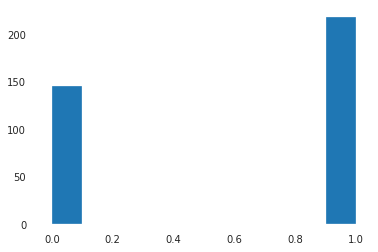

In [48]:
plt.hist(y_train)

(array([ 54.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 102.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

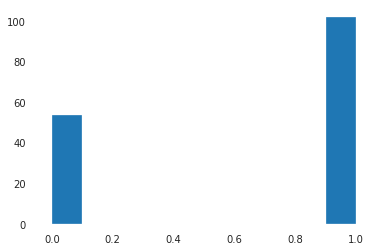

In [49]:
plt.hist(y_test)

In [50]:
from sklearn.compose import ColumnTransformer

### variáveis contínuas que serão padronizadas
continuous_cols = ['Age']


def setScaler():
  ct = ColumnTransformer([
        ('scaler', StandardScaler(), continuous_cols)
    ], remainder='passthrough'
  )
  return ct
  
scaler = setScaler()

In [51]:
scaler.fit(X_train)

ColumnTransformer(n_jobs=None, remainder='passthrough', sparse_threshold=0.3,
                  transformer_weights=None,
                  transformers=[('scaler',
                                 StandardScaler(copy=True, with_mean=True,
                                                with_std=True),
                                 ['Age'])],
                  verbose=False)

In [52]:
X_train = scaler.transform(X_train)

In [53]:
X_test = scaler.transform(X_test)

In [54]:
df_final = pd.DataFrame(X_train, columns=X_train_columns).head(10)
df_final

,Age,Polyuria,Polydipsia,sudden weight loss,weakness,Polyphagia,Genital thrush,visual blurring,Itching,Irritability,delayed healing,partial paresis,muscle stiffness,Alopecia,Obesity,Gender_Female,Gender_Male
0,-1.54877,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1
1,-0.979325,1,1,0,1,1,0,1,1,0,1,1,0,0,0,1,0
2,0.729018,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,1
3,1.94926,1,0,0,0,1,0,1,1,0,1,1,1,1,0,0,1
4,-0.00312883,0,1,1,1,0,0,1,1,1,1,0,0,0,0,0,1
5,0.484969,0,0,0,1,0,0,0,1,0,1,0,1,1,0,0,1
6,1.54251,0,1,0,1,1,0,1,0,1,1,1,1,1,1,0,1
7,-0.816625,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
8,0.566319,1,1,0,1,1,0,1,1,0,1,0,1,1,1,0,1
9,-1.46742,1,1,1,0,1,0,0,0,1,0,1,1,0,0,1,0


In [55]:
def runModel(model, X_train, y_train, X_test, y_test, confusion_matrix=True, normalizeCM=False, roc=True, plot_calibration=True, random_state=42, title="", pos_label=1):
    """Função auxiliar para execução de modelos de classificação.
    
    Parâmetros:
    
    - model: modelo de classificação a ser executado
    - X_train: base de treinamento das variáveis preditoras
    - y_train: base de treinamento da classe
    - X_test: base de teste das variáveis preditoras
    - y_test: base de teste da classe
    - confusion_matrix (default: True): exibir a matriz de confusão da classificação
    - normalizeCM (default: False): define se a matriz de confusão será normalizada
    - roc (default: True): define se será exibida a curva ROC para o classificador
    - plot_calibration (default: True): define se será exibida a curva de calibração para o classificador
    - title: define o título a ser exibido nos gráficos
    - pos_label: indica qual o valor de y_train e y_test que representa a classe positiva. O valor default é 1. 

    """
    clf = model
    name = title
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
        
    if hasattr(clf, "predict_proba"):
        prob_pos = clf.predict_proba(X_test)
    else:  # use decision function
        prob_pos = clf.decision_function(X_test)
        prob_pos = (prob_pos - prob_pos.min()) / (prob_pos.max() - prob_pos.min())
    if confusion_matrix:
       skplt.metrics.plot_confusion_matrix(y_test, y_pred, normalize=normalizeCM, title=name)
    if roc:
       skplt.metrics.plot_roc(y_test, prob_pos, plot_micro=False, plot_macro=False, classes_to_plot=[1], title=name,figsize=(10,10))
               
    prob_pos = prob_pos[:,1]
    clf_score = brier_score_loss(y_test, prob_pos, pos_label=pos_label)
    print("%s:" % name)
    print("\tBrier: %1.3f" % (clf_score))
    print("\tPrecision: %1.3f" % precision_score(y_test, y_pred))
    print("\tRecall: %1.3f" % recall_score(y_test, y_pred))
    print("\tF1: %1.3f\n" % f1_score(y_test, y_pred))
        
    if plot_calibration:
      
      fraction_of_positives, mean_predicted_value = \
                calibration_curve(y_test, prob_pos, n_bins=10)
      plt.rcParams.update({'font.size': 22})
      plt.rc('legend',**{'fontsize':22})
      fig = plt.figure(3, figsize=(10, 10))
      ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
      ax2 = plt.subplot2grid((3, 1), (2, 0))
      ax1.plot([0, 1], [0, 1], "k:", label="Perfeitamente calibrado",)
      ax1.plot(mean_predicted_value, fraction_of_positives, "s-",
                     label="%s (%1.3f)" % (name, clf_score))

      ax2.hist(prob_pos, range=(0, 1), bins=10, label=name,
                     histtype="step", lw=2)

      ax1.set_ylabel("Fração de positivos")
      ax1.set_ylim([-0.05, 1.05])
      ax1.legend(loc="lower right")
      ax1.set_title('Gráfico de Calibração  (reliability curve)')
      
      ax2.set_xlabel("Valor médio predito")
      ax2.set_ylabel("Quantidade")
      ax2.legend(loc="upper center", ncol=2)
      
      for item in ([ax1.title, ax1.xaxis.label, ax1.yaxis.label] +
             ax1.get_xticklabels() + ax1.get_yticklabels()):
        item.set_fontsize(22)
        
      for item in ([ax2.title, ax2.xaxis.label, ax2.yaxis.label] +
             ax2.get_xticklabels() + ax2.get_yticklabels()):
        item.set_fontsize(22)
      
      plt.tight_layout()
      plt.show()

    
    
    

In [56]:
# Utility function to report best scores
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

# regressão logística

Regressão Logística:
	Brier: 0.052
	Precision: 0.951
	Recall: 0.951
	F1: 0.951



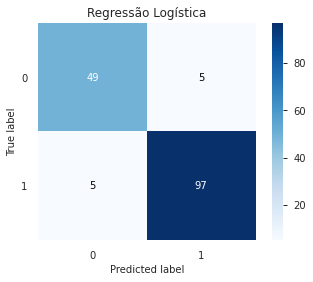

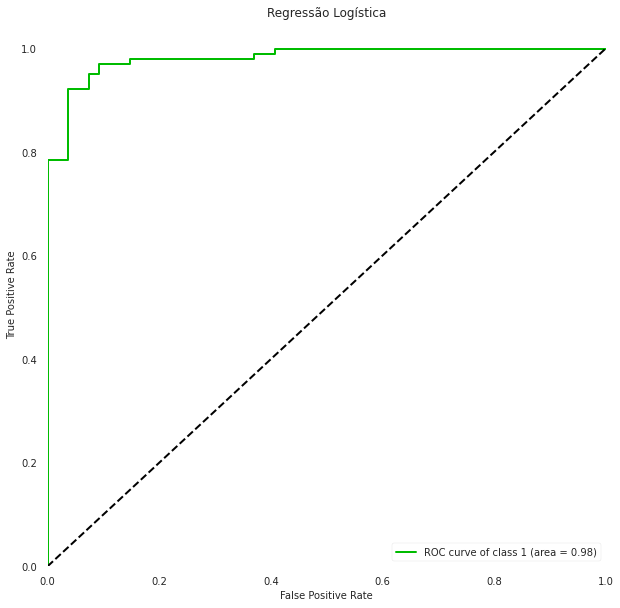

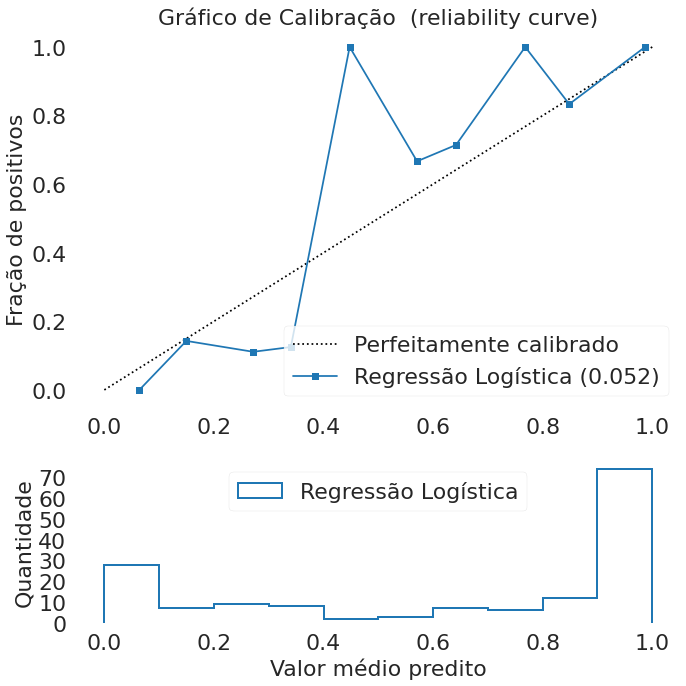

In [57]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
runModel(lr, X_train, y_train, X_test, y_test, title="Regressão Logística")

In [58]:
from sklearn import neural_network

# redes neurais


In [59]:
rna = neural_network.MLPClassifier(activation='tanh', alpha=0.1, batch_size=5, beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=7, learning_rate='constant',
       learning_rate_init=0.1, max_iter=500, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=None, shuffle=True, solver='lbfgs', tol=0.0001,
       validation_fraction=0.1, verbose=True, warm_start=False)

RNA:
	Brier: 0.014
	Precision: 1.000
	Recall: 0.980
	F1: 0.990



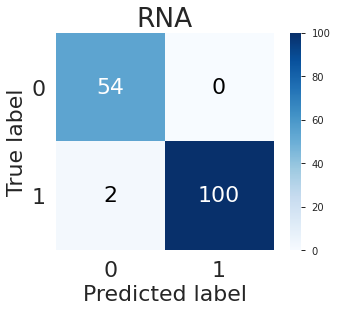

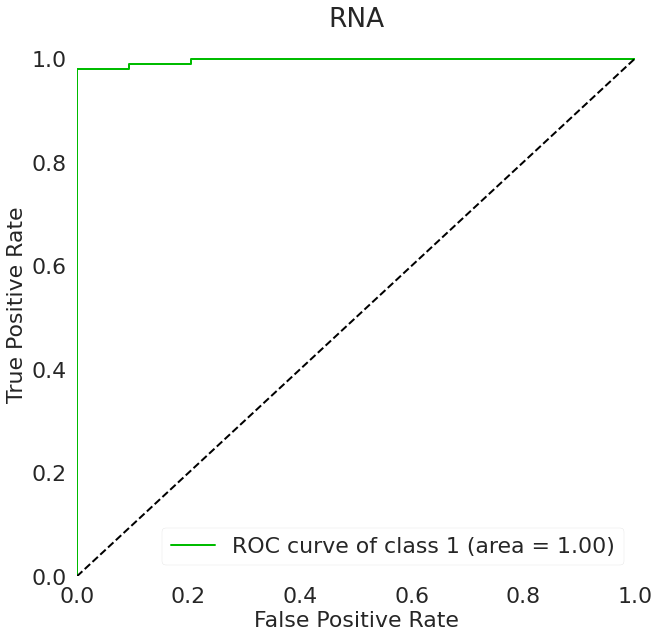

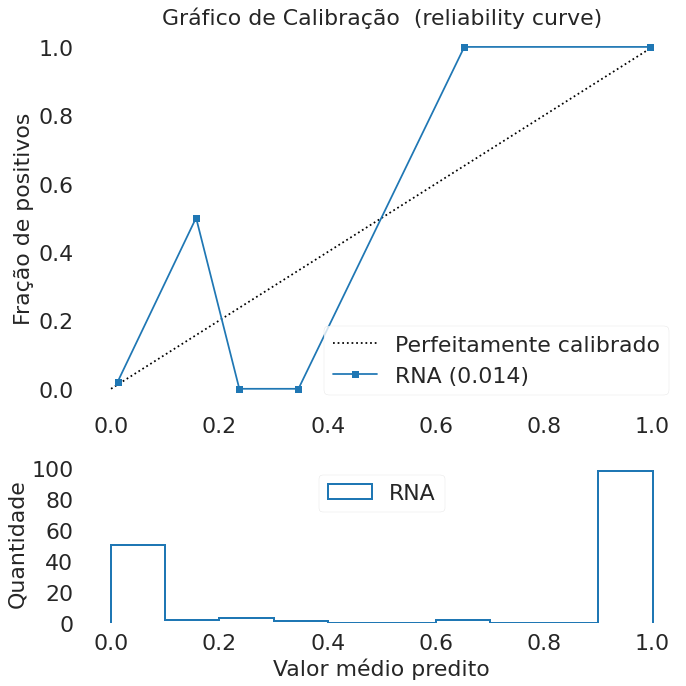

In [60]:
runModel(rna, X_train, y_train, X_test, y_test, title="RNA")

# árvore de decisões

In [61]:
from sklearn.tree import DecisionTreeClassifier
param_grid = {"criterion": ["gini", "entropy"],
              "min_samples_split": [2,5,8,15,20],
              "max_depth": [2,4,6,8,10],
              "min_samples_leaf": [1,2,4,8,10],
              "max_leaf_nodes": [2,4, 7,9, 12, 20],
              }
dt = DecisionTreeClassifier(random_state=42)
cv_dt = GridSearchCV(dt, cv = 3,
                     param_grid=param_grid,
                     n_jobs = -1)

In [62]:
cv_dt.fit(X_train, y_train)

GridSearchCV(cv=3, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=42,
                                              splitter='best'),
             iid='deprecated', n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                       

In [63]:
cv_dt

GridSearchCV(cv=3, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=42,
                                              splitter='best'),
             iid='deprecated', n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                       

In [64]:
report(cv_dt.cv_results_)


Model with rank: 1
Mean validation score: 0.934 (std: 0.020)
Parameters: {'criterion': 'gini', 'max_depth': 6, 'max_leaf_nodes': 20, 'min_samples_leaf': 1, 'min_samples_split': 2}

Model with rank: 1
Mean validation score: 0.934 (std: 0.020)
Parameters: {'criterion': 'gini', 'max_depth': 8, 'max_leaf_nodes': 20, 'min_samples_leaf': 1, 'min_samples_split': 2}

Model with rank: 1
Mean validation score: 0.934 (std: 0.020)
Parameters: {'criterion': 'gini', 'max_depth': 10, 'max_leaf_nodes': 20, 'min_samples_leaf': 1, 'min_samples_split': 2}



In [65]:
dt = DecisionTreeClassifier(criterion='entropy', max_depth=6, max_leaf_nodes=20, min_samples_leaf=10, min_samples_split=20)

Árvore de Decisão:
	Brier: 0.051
	Precision: 0.951
	Recall: 0.961
	F1: 0.956



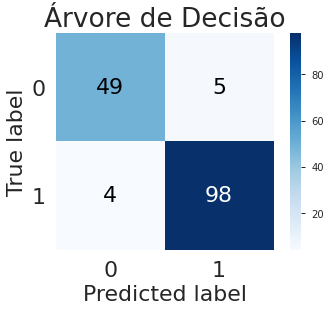

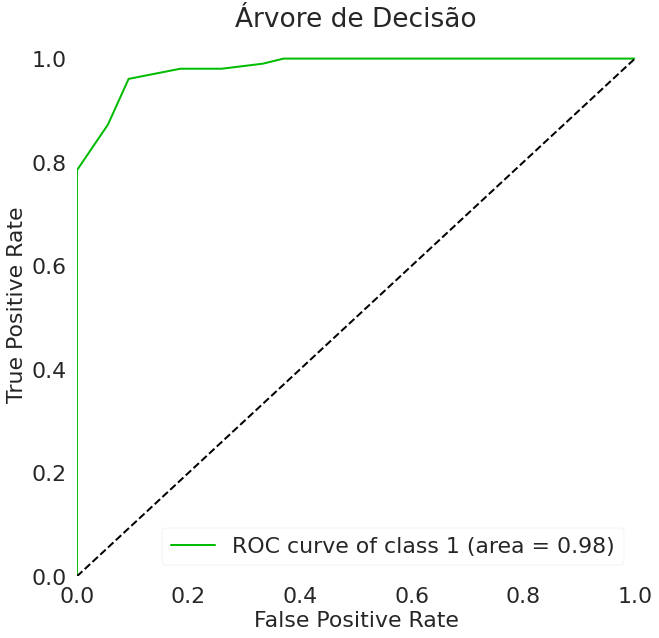

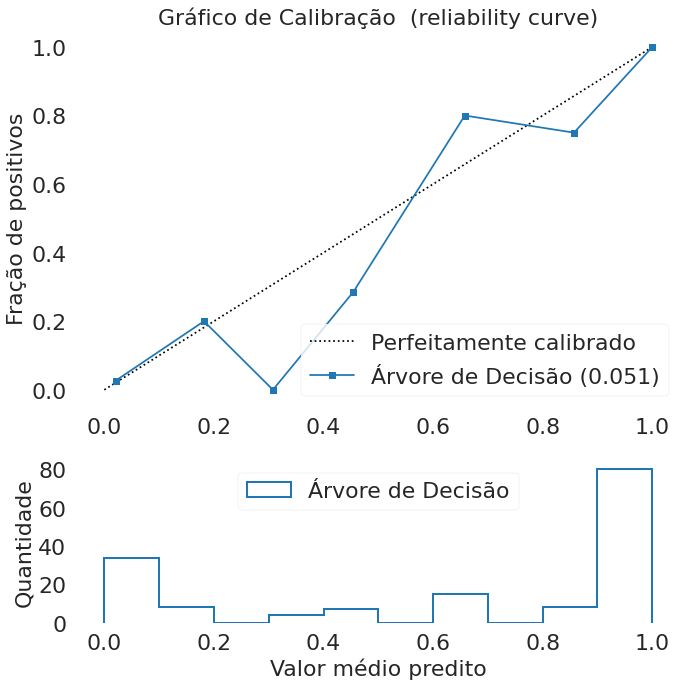

In [66]:
runModel(dt, X_train, y_train, X_test, y_test, title="Árvore de Decisão")

In [67]:
fit_rf = RandomForestClassifier(random_state=42, verbose=1)


# random forest

In [68]:
np.random.seed(42)

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 5)]
# Number of features to consider at every split
max_features = ['log2', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(5, 20, num = 5)]
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the param grid
param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

### Caso deseje rodar GridSearchCV, troque a linha acima pela que segue

cv_rf = GridSearchCV(fit_rf, cv=3, param_grid=param_grid,
                     n_jobs = -1) 

cv_rf = RandomizedSearchCV(fit_rf, n_iter=50, cv=3, verbose=1, param_distributions=param_grid,
                     n_jobs = -1)



In [69]:
cv_rf.fit(X_train, y_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   32.5s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  1.5min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 775 out of 775 | elapsed:    0.5s finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
               

In [70]:
rf = cv_rf.best_estimator_

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 775 out of 775 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 775 out of 775 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 775 out of 775 | elapsed:    0.1s finished


Random Forest:
	Brier: 0.019
	Precision: 1.000
	Recall: 0.990
	F1: 0.995



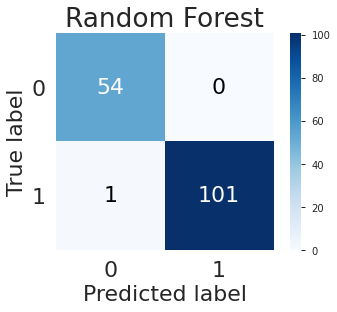

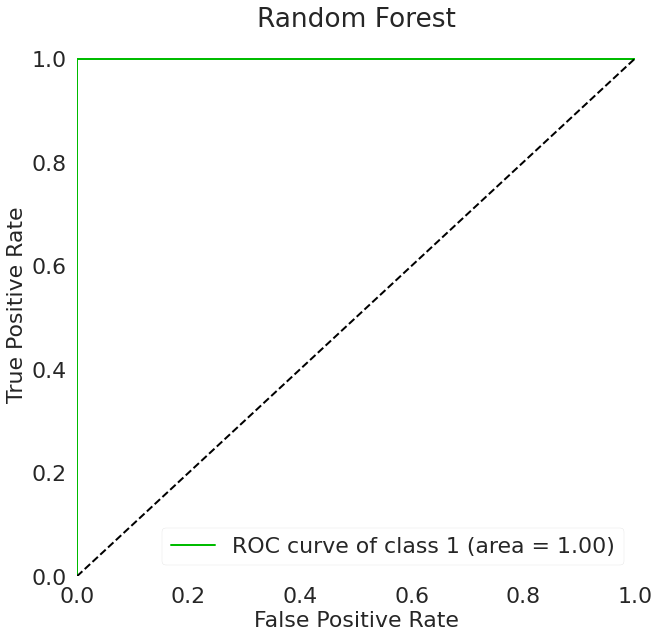

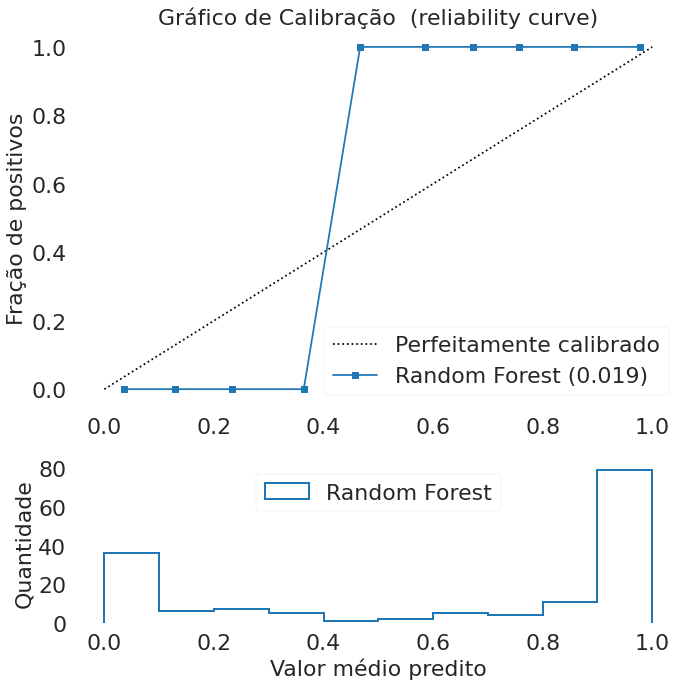

In [71]:
runModel(rf, X_train, y_train, X_test, y_test, title="Random Forest")